A simple filter for regimes

In [29]:
import pandas as pd
import numpy as np

In [39]:
# parameters
ma = 120

In [40]:
df = pd.read_csv('/home/pi/data/nifty.csv', parse_dates=['Date']).rename(
columns = lambda x:x.lower()).sort_values(by='date').set_index('date')
df['ret'] = df.close.pct_change()
df.tail()

,open,high,low,close,ret
date,,,,,
2021-09-30,17718.90,17742.15,17585.35,17618.15,-0.005259
2021-10-01,17531.90,17557.15,17452.90,17532.05,-0.004887
2021-10-04,17615.55,17750.90,17581.35,17691.25,0.009081
2021-10-05,17661.35,17833.45,17640.90,17822.30,0.007408
2021-10-06,17861.50,17884.60,17613.15,17646.00,-0.009892


Let us add the following columns

1. moving average for price
2. 60 day volatility

In [64]:
df['ma_price'] = df.close.rolling(ma).mean()
df['volatility'] = df.ret.rolling(ma).std()*np.sqrt(252)
df['ma_volatility'] = df.volatility.rolling(ma).median()
df['is_price'] = df.eval('close > ma_price')+0
df['is_volatile'] = df.eval('volatility > ma_volatility')+0
df['is_price'] = df.is_price.shift(1)
#df['is_volatile'] = df.is_volatile.shift(1)

In [65]:
df.groupby(['is_price']).ret.describe()

,count,mean,std,min,25%,50%,75%,max
is_price,,,,,,,,
0.0,1985.0,0.000069,0.018326,-0.129805,-0.008919,0.000833,0.009478,0.087632
1.0,3428.0,0.000826,0.011536,-0.087024,-0.004927,0.000988,0.006949,0.177441


In [43]:
df['year'] = df.index.year
df['month'] = df.index.month
from fastbt.utils import streak
df['streak'] = streak(df.is_price.values)

In [44]:
df.shape

(5414, 13)

In [45]:
strk = df.groupby('streak').size()
strk.diff().abs()

streak
1.0       NaN
2.0      49.0
3.0      13.0
4.0      14.0
5.0      13.0
         ... 
280.0     0.0
281.0     0.0
282.0     0.0
283.0     0.0
284.0     0.0
Length: 284, dtype: float64

<AxesSubplot:xlabel='date'>

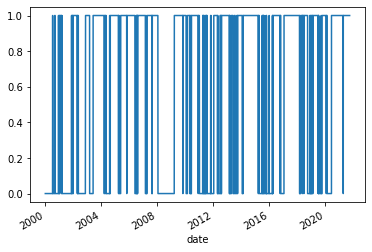

In [46]:
df.loc['2000':].is_price.plot()

In [47]:
market_map = {
    (0,0): 'bear-low',
    (0,1): 'bear-high',
    (1,0): 'bull-low',
    (1,1): 'bull-high'
}
env_map = {
    'bear-low': 0,
    'bear-high': -1,
    'bull-low': 1,
    'bull-high': 2
}
df['mm'] = [market_map.get((x,y)) for x,y in zip(df.is_price, df.is_volatile)]
df['em'] = df.mm.map(env_map)